In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import ase.units

Hartree = ase.units.Hartree
Bohr = ase.units.Bohr

In [2]:
# Plot layout
from matplotlib import rcParams
rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["Computer Modern Roman"],
    "font.size": 16})
rcParams['axes.titlepad'] = 20

In [3]:
nFilling = 1
nPadding = 0
def load_qeh_data(fileprefix, nFilling=1, nPadding=0):
    qeh_data = np.load(fileprefix + '_nFilling=' + str(nFilling) + '_nPadding=' + str(nPadding)+ '.npz')
    return qeh_data
qeh_data = load_qeh_data('vdWH')
E_b = qeh_data['E_b']
E_b_analytic = qeh_data['E_b_analytic']
E_b_analytic_const_d = qeh_data['E_b_analytic_const_d']

E_b_heat_mat = qeh_data['E_b_heat_mat']
E_b_analytic_heat_mat = qeh_data['E_b_analytic_heat_mat']
E_b_analytic_const_d_heat_mat = qeh_data['E_b_analytic_const_d_heat_mat']
E_b_heat_xlabels = [l[4:] for l in qeh_data['E_b_heat_xlabels']]
E_b_heat_ylabels = [l[4:] for l in qeh_data['E_b_heat_ylabels']]
bilayers = qeh_data['bilayers']

d0 = np.round(np.mean(qeh_data['distances']),1)

vmin = np.min(np.hstack([E_b, E_b_analytic, E_b_analytic_const_d]))*10**3
vmax = np.max(np.hstack([E_b, E_b_analytic, E_b_analytic_const_d]))*10**3

In [4]:
# Sort by qeh-matrix
argsort_row = np.argsort(np.mean(E_b_heat_mat, axis=1))[::-1]
argsort_col = np.argsort(np.mean(E_b_heat_mat[argsort_row,:], axis=0))
E_b_sorted = E_b_heat_mat[argsort_row,:][:,argsort_col]
E_b_analytic_sorted = E_b_analytic_heat_mat[argsort_row,:][:,argsort_col]
E_b_analytic_const_d_sorted = E_b_analytic_const_d_heat_mat[argsort_row,:][:,argsort_col]

xlabels_sorted = np.take(E_b_heat_xlabels,argsort_col)
ylabels_sorted = np.take(E_b_heat_ylabels,argsort_row)

# Assert that sorting preserves data values at correct indices:
for i_x, xlabel in enumerate(E_b_heat_xlabels):
    for i_y, ylabel in enumerate(E_b_heat_ylabels):
        i_x_sorted = int(np.where(xlabels_sorted == xlabel)[0])
        i_y_sorted = int(np.where(ylabels_sorted == ylabel)[0])
        assert E_b_heat_mat[i_y, i_x] == E_b_sorted[i_y_sorted, i_x_sorted]
        assert E_b_analytic_heat_mat[i_y, i_x] == E_b_analytic_sorted[i_y_sorted, i_x_sorted]
        assert E_b_analytic_const_d_heat_mat[i_y, i_x] == E_b_analytic_const_d_sorted[i_y_sorted, i_x_sorted]

In [5]:
def heatmap(data, xlabels, ylabels, cbarlabel, show_annotations, xlabel, ylabel, cmap, **kwargs):
    # if not ax:
    #     ax = plt.gca()
    
    plt.imshow(data, cmap=cmap, **kwargs)

    if xlabel != '' or ylabel != '':
        plt.xlabel(xlabel, fontsize = 20)
        plt.ylabel(ylabel, fontsize = 20)
    # Magic code to make colorbar span height of plot
    im_ratio = data.shape[0]/data.shape[1]
    cb = plt.colorbar(label=cbarlabel,fraction=0.046*im_ratio, pad=0.04)
    cb.ax.plot([0,1], [0.5, 0.5], 'w')
    cb_x_min, cb_x_max = cb.ax.get_xlim() 
    cb_y_min, cb_y_max = cb.ax.get_ylim()
    cb.ax.plot([cb_x_min,cb_x_max], [np.min(data) + 1.2, np.min(data) + 1.2], 'r')
    cb.ax.plot([cb_x_min,cb_x_max], [np.max(data) - 3, np.max(data) - 3], 'r')
    # cbar.ax.set_ylabel(cbarlabel, rotation=0, va="bottom")

    if show_annotations:
        plt.xticks(np.arange(len(xlabels)), labels=xlabels)
        plt.yticks(np.arange(len(ylabels)), labels=ylabels)

        for ticklabel, label in zip(plt.gca().get_xticklabels() + plt.gca().get_yticklabels(), list(xlabels) + list(ylabels)):
            if 'O2' in label:
                ticklabel.set_color('darkred')
            # else:
            #     ticklabel.set_color('tab:green')

        # Loop over data dimensions and create text annotations.
        for i in range(len(ylabels)):
            for j in range(len(xlabels)):
                # Uncomment this block to ensure
                # text color has enough contrast
                # with background to be readable.
                colors = ['k', 'w']
                # We can also use color map instead of black and white:
                # color_map = plt.get_cmap(cmap)
                # colors = [color_map(1.0), color_map(0.0)]
                color = colors[int(data[i,j] > np.quantile(data, 0.975))]
                # color = colors[int(data[i,j] > vmin+0.75*(vmax-vmin))]

                # # Alternatively: Choose always black text
                # color = 'k'
                if data[i, j] != 0:
                    plt.text(j, i, data[i, j], ha="center", va="center", color=color)
    else:
        # plt.xticks(np.arange(len(xlabels)), labels=[l[2:] for l in xlabels])
        # plt.yticks(np.arange(len(ylabels)), labels=[l[2:] for l in ylabels])
        plt.xticks(np.arange(len(xlabels)), labels=xlabels)
        plt.yticks(np.arange(len(ylabels)), labels=ylabels)
        #plt.xticks(np.arange(len(xlabels)), labels=['Ox.' if 'O2' in label else 'TMD' for label in xlabels])
        #plt.yticks(np.arange(len(ylabels)), labels=['Ox.' if 'O2' in label else 'TMD'for label in ylabels])

        for ticklabel, label in zip(plt.gca().get_xticklabels() + plt.gca().get_yticklabels(), list(xlabels) + list(ylabels)):
            if 'O2' in label:
                ticklabel.set_color('darkred')
            # else:
            #     ticklabel.set_color('tab:green')
    plt.xticks(rotation=90, ha='center')

def plot_E_b(E_b_heat_mat,xlabels,ylabels, cbarlabel = r'$E_b$ [meV]', file_ending='unknown', show_annotations=True, xlabel='', ylabel='', **kwargs):
    heatmap(np.round(E_b_heat_mat*10**3).astype(int),
        xlabels, ylabels, cbarlabel=cbarlabel, show_annotations=show_annotations,
        cmap='Blues', xlabel=xlabel, ylabel=ylabel, **kwargs)
    plt.tight_layout()
    plt.savefig('./plots/E_b_' + file_ending + '.pdf')
    plt.savefig('./plots/E_b_' + file_ending + '.png')
    plt.show()

In [6]:
xlabel, ylabel = r'\textbf{p-doped monolayer}', r'\textbf{n-doped monolayer}'

In [9]:
# # Ab initio Exciton Binding energies
# fig = plt.figure(1, figsize=(15,8.5))
# # plot_E_b(E_b_sorted, xlabels_sorted, ylabels_sorted, cbarlabel = r'$E_b$ [meV] using ab initio $\epsilon^i$', file_ending='qeh_sorted', xlabel=xlabel, ylabel=ylabel, vmin=vmin, vmax=vmax)
# plot_E_b(E_b_sorted, xlabels_sorted, ylabels_sorted, cbarlabel = r'$E_b$ [meV]', file_ending='qeh_sorted', xlabel=xlabel, ylabel=ylabel, vmin=vmin, vmax=vmax)

In [14]:
gap_eq_data = np.load('./gap_eq_data_QEH.npz')
_names_gap = gap_eq_data['names']
bilayers_gap = gap_eq_data['bilayers']
names_gap = [', '.join(name.split('_')[:-2]) for name in _names_gap]
dens = gap_eq_data['dens']
densarray = gap_eq_data['densarray']
delta = gap_eq_data['delta']
condfrac = gap_eq_data['condfrac']

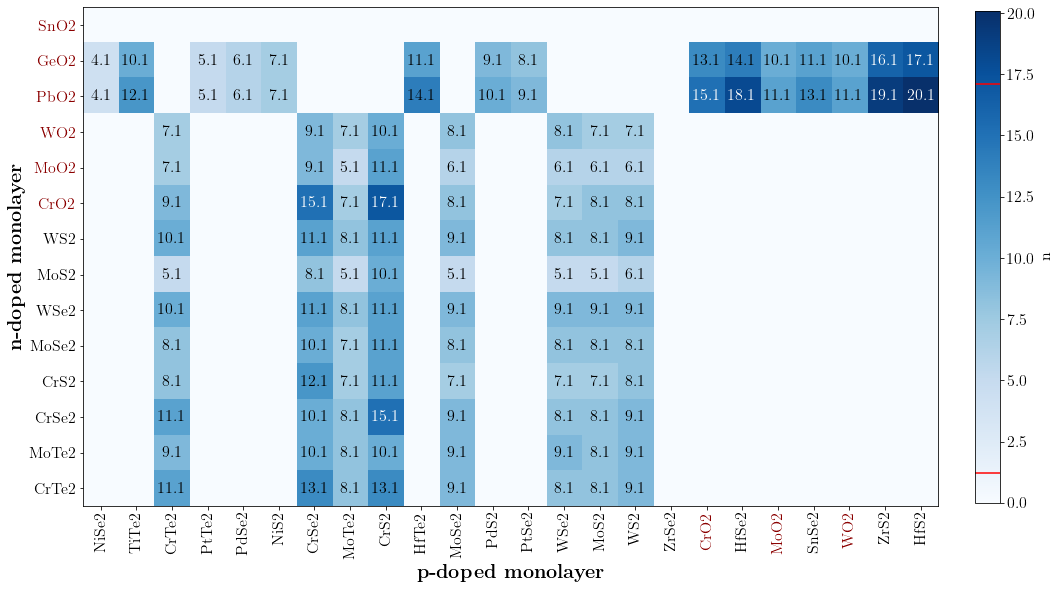

In [17]:
names_gap_clean = [l.replace('-H-', '-').replace('-T-', '-').replace('n-', '').replace('p-', '').split(', ') for l in bilayers_gap]
cutoff_dens = np.empty(E_b_heat_mat.shape)
for i_e, e_layer in enumerate(ylabels_sorted):
    for i_h, h_layer in enumerate(xlabels_sorted):
        layer = [e_layer, h_layer]
        if layer in names_gap_clean:
            cutoff_dens[i_e, i_h] = dens[names_gap_clean.index(layer)]
        else:
            cutoff_dens[i_e, i_h] = 0

fig = plt.figure(1, figsize=(15,8.5))
heatmap(np.round(cutoff_dens*10**4,1),
        xlabels_sorted, ylabels_sorted, cbarlabel='n', show_annotations=True,
        cmap='Blues', xlabel=xlabel, ylabel=ylabel)
plt.tight_layout()
plt.show()

In [30]:
n_G = ['GeO2', 'PbO2', 'SnO2']
n_K = ['CrO2', 'CrS2', 'CrSe2', 'CrTe2', 'MoO2', 'MoS2', 'MoSe2', 'MoTe2', 'WO2', 'WS2', 'WSe2']
p_G = ['CrO2', 'HfTe2', 'MoO2', 'TiTe2', 'WO2', 'HfS2', 'HfSe2', 'NiS2', 'NiSe2', 'PdS2', 'PdSe2', 'PtSe2', 'PtTe2', 'SnSe2', 'ZrS2', 'ZrSe2']
p_K = ['CrS2', 'CrSe2', 'CrTe2', 'MoS2', 'MoSe2', 'MoTe2', 'WS2', 'WSe2']

for bilayer in bilayers_gap:
    e_layer, h_layer = bilayer.replace('-T-', '-').replace('-H-', '-').replace('n-', '').replace('p-', '').split(', ')
    if e_layer in n_G:
        if h_layer not in p_G:
            print(h_layer, ' not in p_G')
    if e_layer in n_K:
        if h_layer not in p_K:
            print(h_layer, ' not in p_K')

    if h_layer in p_G:
        if e_layer not in n_G:
            print(e_layer, ' not in n_G')
    if h_layer in p_K:
        if e_layer not in n_K:
            print(h_layer, ' not in n_K')